In [1]:
%load_ext autoreload
%autoreload 2


In [5]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult, get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Visualization Testing

In [6]:
# FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
action = ''
RUNTIME=2.0

In [27]:
name = f"sarfa_baseline_{int(RUNTIME * 10)}"
board = chess.Board(FEN)
engine = Engine("./stockfish_15_x64_avx2")
board_visualization = BoardVisualization(board)


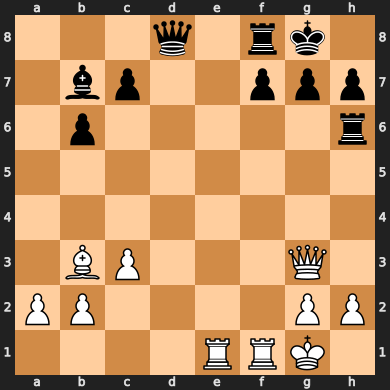

In [8]:
board_visualization.only_board()

# Sarfa (without defined action)

In [9]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board)
for perturbed_board, perturbed_position_str in perturber.process():

    sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)
    saliency_results[perturbed_position_str] = sarfa_compute_result.saliency
    print(f"{perturbed_position_str} removed: {sarfa_compute_result.saliency}")

a2 removed: 0.6100578956497222
b2 removed: 0.08022940198152823
b3 removed: 0.6992049337797575
b6 removed: 0.024756890499496146
b7 removed: 0.6697639488396626
c3 removed: 0.9884999369706191
c7 removed: 0.8227794204402822
d8 removed: 0
e1 removed: 0.7045135973351921
f1 removed: 0.34333305117157664
f7 removed: 0
f8 removed: 0.08385650161885373


KeyboardInterrupt: 

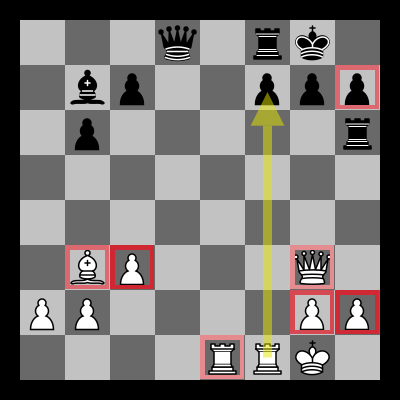

In [ ]:
path = board_visualization.show_heatmap(saliency_results, chess.Move.from_uci(sarfa_compute_result.optimal_move))
display(Image(path))

# Sarfa Baseline with Move

In [38]:
board = chess.Board("3q2k1/1bp2rpp/1p5r/8/8/1BP3Q1/PP4PP/4R1K1 w - - 0 2")
board_visualization = BoardVisualization(board)
action: chess.Move = chess.Move.from_uci("g3c7")

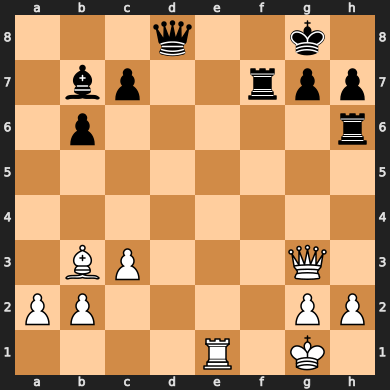

In [39]:
board_visualization.only_board()

In [50]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board, runtime=2)
for perturbed_board, perturbed_position_str in perturber.process():

    sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, action)
    saliency_results[perturbed_position_str] = sarfa_compute_result.saliency
    print(f"{perturbed_position_str} removed: {sarfa_compute_result.saliency} \t {sarfa_compute_result}")
    if perturbed_position_str == "g7":
        break


a2 removed: 0.008150802185373542 	 SarfaComputeResult(saliency=0.008150802185373542, dP=0.004095268924691808, optimal_move='g3c7')
b2 removed: 0.01199321443876336 	 SarfaComputeResult(saliency=0.01199321443876336, dP=0.006039984828897116, optimal_move='g3c7')
b3 removed: 0.6240180011675001 	 SarfaComputeResult(saliency=0.6240180011675001, dP=0.9626462007392401, optimal_move='g3c7')
b6 removed: 0 	 SarfaComputeResult(saliency=0, dP=-0.0030254044855114737, optimal_move='g3c7')
b7 removed: 0 	 SarfaComputeResult(saliency=0, dP=-0.004985722749081267, optimal_move='g3c7')
c3 removed: 0.8293053136405594 	 SarfaComputeResult(saliency=0.8293053136405594, dP=0.9665829753023653, optimal_move='g3c7')
c7 removed: 0.04184793712508797 	 SarfaComputeResult(saliency=0.04184793712508797, dP=0.02212900345651958, optimal_move='g3c7')
d8 removed: 0.05347946511772906 	 SarfaComputeResult(saliency=0.05347946511772906, dP=0.6616809439175828, optimal_move='g3c7')
e1 removed: 0.637885693817202 	 SarfaComputeRe

In [51]:
perturbed_board.was_into_check()

True

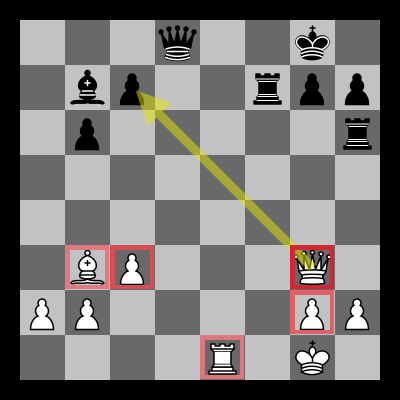

In [52]:
path = board_visualization.show_heatmap(saliency_results, action)
display(Image(path))

# Benchmarking

In [10]:
from chess_dataset import SafraBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [20]:
def saliency_algorithm(fen, action=None) -> dict[str, float]:
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board, runtime=RUNTIME)
    for perturbed_board, perturbed_position_str in perturber.process():
        saliency_result = saliency_calculator.compute(perturbed_board, 
        action)
        saliency_results[perturbed_position_str] = saliency_result.saliency

    return saliency_results


In [22]:
benchmark = SafraBenchmark(saliency_algorithm, name, sanity_check=True)

2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1
r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1
2r4k/3r1p1p/1p2pP2/p2pPp1P/P2P1Q2/6R1/4B1PK/2q5 w - - 0 1
R4rk1/5bb1/1N1Qpq1p/3pn1p1/3N4/2P2P1P/P5P1/5B1K w - - 0 1
5r1k/bp4pp/1n6/5qN1/1PR5/P2Q3P/5PP1/6K1 w - - 0 1


In [23]:
benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7902174632702069}

In [24]:
fpr, tpr = benchmark.roc_curve()
roc_auc = auc(fpr, tpr)


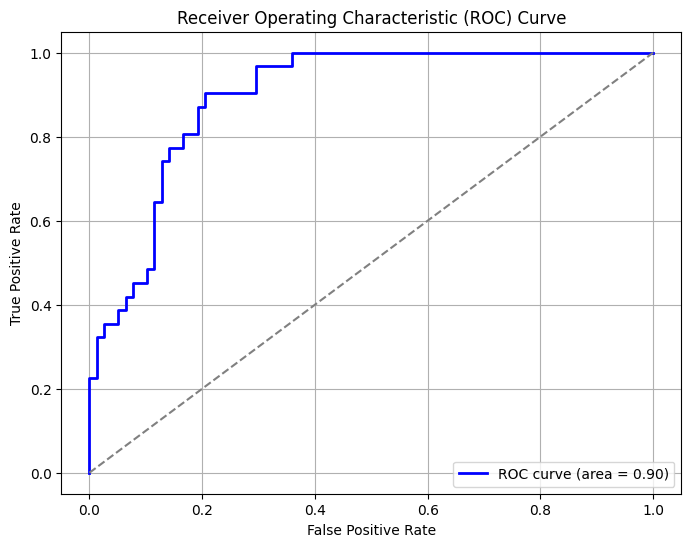

In [25]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Loading

In [30]:
import pickle

# Load from file
with open(f"output/{name}.0.pkl", "rb") as f:
    loaded_data = pickle.load(f)

predicted_values_array, ground_truth, index_to_position_strs = loaded_data
print(predicted_values_array)
print(ground_truth)
print(index_to_position_strs)


[0.00000000e+00 1.47190261e-02 5.53041878e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.43094524e-01 0.00000000e+00 5.34267815e-01
 3.91479665e-01 5.33317158e-01 3.82718009e-01 3.55961279e-01
 0.00000000e+00 1.00000000e+00 7.63870411e-03 6.01295627e-02
 9.59636580e-02 4.35737562e-02 4.68911256e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.47937506e-01
 0.00000000e+00 0.00000000e+00 8.32321394e-01 4.53585637e-02
 0.00000000e+00 2.64964877e-01 3.68076582e-02 0.00000000e+00
 0.00000000e+00 1.00000000e+00 8.80920585e-01 5.24066305e-02
 0.00000000e+00 8.27088028e-01 8.20968253e-01 8.03579504e-01
 0.00000000e+00 6.49986874e-01 2.88016021e-01 1.67589215e-01
 8.40747349e-01 2.66986290e-01 0.00000000e+00 6.61054037e-01
 8.40896136e-01 8.27719729e-01 0.00000000e+00 0.00000000e+00
 1.00000000e+00 7.58798796e-03 1.55704525e-01 4.74239905e-03
 1.20550958e-03 3.16713314e-03 9.87414019e-01 7.19387573e-02
 3.55756820e-03 3.253799

# ---------------

# Sequential SARFA

## Sanity Check

In [96]:
engine = Engine("./stockfish_15_x64_avx2")
saliency_results_per_step = []
actions = []

def sequential_saliency_algorithm(fen, discount_factor, depth):
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board)
        
        for perturbed_board, perturbed_position_str in perturber.process():
            saliency, optimal_move_original_board = saliency_calculator.compute(perturbed_board, None)

            optimal_move = optimal_move_original_board
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (saliency * (discount_factor ** curr_step))
        
        saliency_results_per_step.append((saliency_results.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        optimal_move_obj = chess.Move.from_uci(optimal_move)
        actions.append(optimal_move_obj)
        board.push(optimal_move_obj)
        saliency_calculator.original_board_actions = set(board.legal_moves) 

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break



    return saliency_results

In [97]:
# fen = 'r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1
fen = "6k1/2n1b1r1/r1qRp1p1/2p1PpNp/1pP2P1P/pP2B3/P2Q2P1/3R2K1 w - - 0 1"
discount_factor = 0.9
depth = 3
saliency_results = sequential_saliency_algorithm(fen, discount_factor, depth)

curr step: 0
curr step: 1
curr step: 2


In [98]:
print(fen)

6k1/2n1b1r1/r1qRp1p1/2p1PpNp/1pP2P1P/pP2B3/P2Q2P1/3R2K1 w - - 0 1


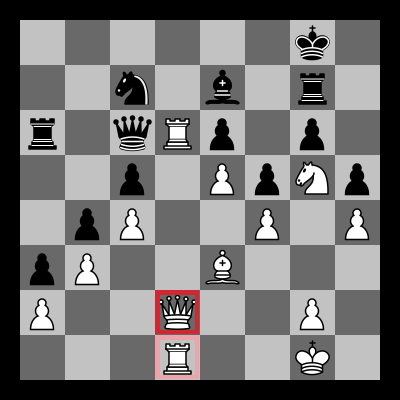

In [99]:
board_visualization = BoardVisualization(chess.Board(fen))
path = board_visualization.show_heatmap(saliency_results, None)
display(Image(path))

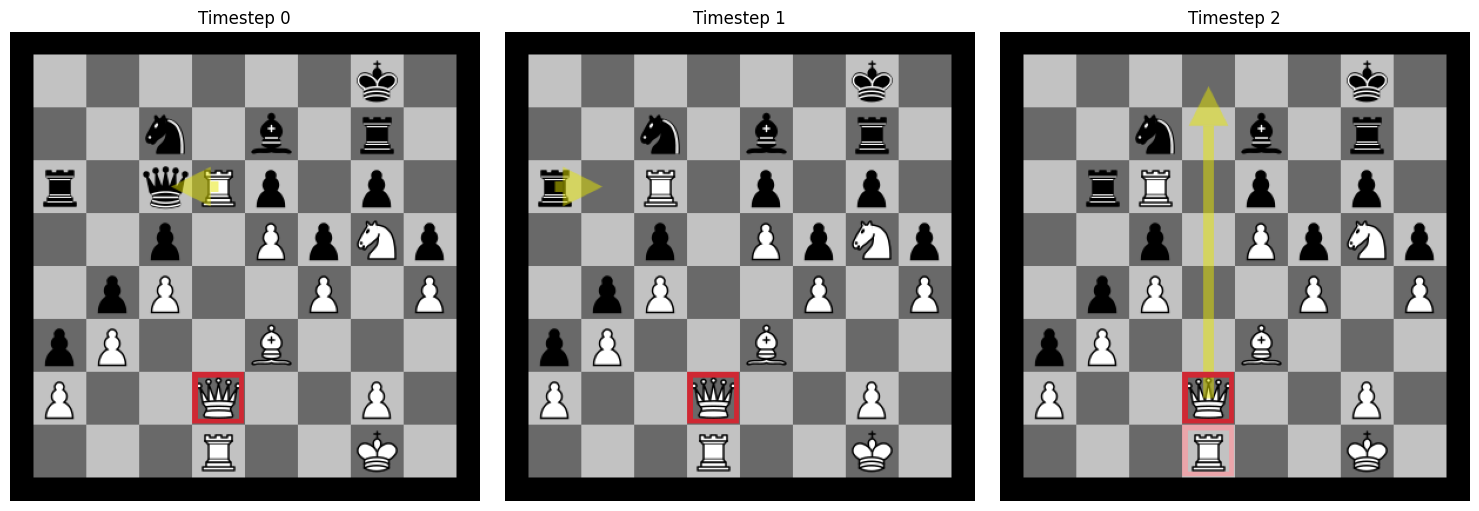

In [100]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Create a grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, depth, figsize=(15, 5))  # Adjust the size as needed

# Loop through indices 1 through 3
for step in range(depth):  # 1 through 3 inclusive
    board_visualization = BoardVisualization(saliency_results_per_step[step][1])
    path = board_visualization.show_heatmap(saliency_results_per_step[step][0], actions[step])
    img = PILImage.open(path)
    
    # Display the image in the corresponding subplot
    axes[step].imshow(img)
    axes[step].axis('off')  # Turn off axis
    axes[step].set_title(f"Timestep {step}", fontsize=12)

# Adjust layout and show the grid
plt.tight_layout()
plt.show()


In [107]:
benchmark = SafraBenchmark(lambda x, _: sequential_saliency_algorithm(x, 0.9, 3))

curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
9
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
19
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
game finished ear

TypeError: object of type 'NoneType' has no len()